# Lab 2: Variational autoencoders

In this lab, we explore variational autoencoders (VAEs), which are deep generative models composed of an encoder and a decoder.
The encoder maps the input points to a distribution in a latent space and the decoder is able to generate new points by mapping points from the latent space to the input space.

## 0. Preconfiguration

We check that a GPU is available.

In [1]:
import torch

torch.cuda.is_available()

True

If you use Google Colab and the above code returns False, click on `Runtime`, `Change runtime type`, and choose `T4 GPU`. Then run the notebook again from the start.

We import useful libraries.

In [2]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

## 1. Dataset visualization

We define different hyperparameters and constants.

In [3]:
height, width = 28, 28
X_dim = height * width

base_channel_dim = 1 # The images are binary images with a single channel.
kernel_size = 3
C_dim = 16 # Number of channels in the first hidden layer of the encoder.
H_dim = 64
Z_dim = 2

num_epochs = 5
batch_size = 128
device = 'cuda'

We load the dataset and normalize it to help neural network optimization.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
     # We normalize the data to have zero mean and unit standard deviation using precomputed values.
    transforms.Normalize((0.1307,), (0.3081,)),
     # We simplify the problem by transforming the gray images to binary images.
    lambda x: x > 0,
])
train_data = MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

We plot the first batch of training data.

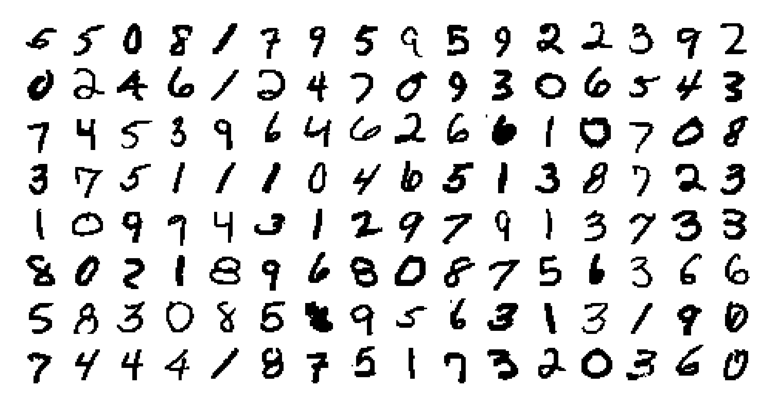

In [5]:
def plot_images(images, ncols=16):
    grid = torchvision.utils.make_grid(images, nrow=ncols)
    # In `make_grid`, `nrow` is a misnomer and represents the number of columns.
    fig, axis = plt.subplots(dpi=150)
    axis.imshow(grid[0], cmap='binary')
    axis.axis('off')
    return fig

first_batch = next(iter(train_loader))[0]
plot_images(first_batch.float())
plt.show()

We observe that we have about 6000 samples per digit.

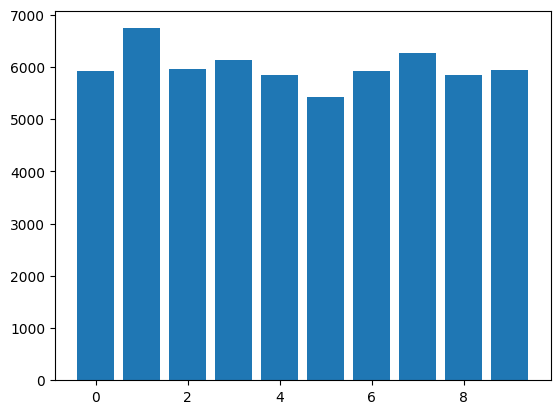

In [6]:
all_labels = torch.cat([labels for _, labels in train_loader])
plt.bar(range(10), np.bincount(all_labels))
plt.show()

## 2. Training a variational autoencoder

We define the encoders and decoders using a convolutional architecture.
In this course, we do not require to understand the specifics of the architecture.

Note that the encoder produces a normal distribution for each dimension of the latent space and the decoder produces a Bernouilli distribution for each pixel of the input space.

In [7]:
def conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, **kwargs):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, **kwargs)

def conv_transpose2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, **kwargs):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding=padding, **kwargs)


class Encoder(nn.Module):
    def __init__(self, C_dim, H_dim, Z_dim):
        super().__init__()
        layers = [
            # base_channel_dim, 28, 28
            conv2d(in_channels=base_channel_dim, out_channels=C_dim, stride=1), nn.ReLU(),
            conv2d(in_channels=C_dim, out_channels=C_dim * 2, stride=2), nn.ReLU(),
            # C_dim * 2, 14, 14
            conv2d(in_channels=C_dim * 2, out_channels=C_dim * 2, stride=1), nn.ReLU(),
            conv2d(in_channels=C_dim * 2, out_channels=C_dim * 4, stride=2), nn.ReLU(),
            # C_dim * 4, 7, 7
            conv2d(in_channels=C_dim * 4, out_channels=C_dim * 4, stride=1),
            nn.Flatten(),
            # C_dim * 4 * 7 * 7
            nn.Linear(C_dim * 4 * 7 * 7, H_dim), nn.ReLU(),
            # H_dim
            nn.Linear(H_dim, 2 * Z_dim),
            # 2 * Z_dim
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # We scale the values to the [-1, 1] interval.
        x = (x - 0.5) * 2
        mu, rho = torch.chunk(self.model(x), 2, dim=1)
        return D.Independent(D.Normal(mu, F.softplus(rho)), 1)


class Decoder(nn.Module):
    def __init__(self, C_dim, H_dim, Z_dim):
        super().__init__()
        layers = [
            # Z_dim
            nn.Linear(Z_dim, H_dim), nn.ReLU(),
            # H_dim
            nn.Linear(H_dim, C_dim * 4 * 7 * 7), nn.ReLU(),
            # C_dim * 4 * 7 * 7
            nn.Unflatten(1, (C_dim * 4, 7, 7)),
            # C_dim * 4, 7, 7
            conv_transpose2d(in_channels=C_dim * 4, out_channels=C_dim * 4, stride=1), nn.ReLU(),
            conv_transpose2d(in_channels=C_dim * 4, out_channels=C_dim * 2, stride=2, output_padding=1), nn.ReLU(),
            # C_dim * 2, 14, 14
            conv_transpose2d(in_channels=C_dim * 2, out_channels=C_dim * 2, stride=1), nn.ReLU(),
            conv_transpose2d(in_channels=C_dim * 2, out_channels=C_dim, stride=2, output_padding=1), nn.ReLU(),
            # C_dim, 28, 28
            conv_transpose2d(in_channels=C_dim, out_channels=base_channel_dim, stride=1),
            # 1, 28, 28
            nn.Sigmoid(),
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, z):
        probs = self.model(z)
        return D.Independent(D.Bernoulli(probs), 3)

We instantiate the encoder and decoder and count the number of parameters.

In [8]:
encoder = Encoder(C_dim, H_dim, Z_dim).to(device)
decoder = Decoder(C_dim, H_dim, Z_dim).to(device)

def params_count(model):
    return sum(p.numel() for p in model.parameters())

print('Total parameters of the encoder:', params_count(encoder))
print('Total parameters of the decoder:', params_count(decoder))

Total parameters of the encoder: 270500
Total parameters of the decoder: 273441


The prior distribution is a standard normal distribution over the latent space.

In [9]:
prior = D.Independent(D.Normal(torch.zeros(Z_dim).to(device), torch.ones(Z_dim).to(device)), 1)

The training loop based on gradient descent is defined here.

The loss is called the ELBO and is composed of two terms:
1. `reconstruction_loss` encourages the accurate reconstruction of the input data.
2. `complexity_loss` penalizes deviations of the variational distribution from the prior distribution of the latent variables.

In [10]:
def train(encoder, decoder, train_loader, num_epochs):
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    step = 0
    for epoch in range(num_epochs):
        for x, _ in train_loader:
            x = x.to(device).float()
            # ===== Forward pass =====
            z_dist = encoder(x)
            z = z_dist.rsample()
            x_dist = decoder(z)
            # ===== Loss =====
            reconstruction_loss = -x_dist.log_prob(x).mean()
            complexity_loss = D.kl_divergence(z_dist, prior).mean()
            loss = reconstruction_loss + complexity_loss
            # ===== Backward pass =====
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===== Logging =====
            if step % 100 == 0:
                print(f'epoch [{epoch + 1}/{num_epochs}], step {step + 1}, loss:{loss.item():.4f}')
            step += 1

To avoid waiting, if you already trained a model, you can skip this cell and load a pre-trained model using the next cell.

In [10]:
train(encoder, decoder, train_loader, num_epochs)

# Save the model parameters.
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

epoch [1/5], step 1, loss:621.8631
epoch [1/5], step 101, loss:232.5186
epoch [1/5], step 201, loss:188.6579
epoch [1/5], step 301, loss:171.9542
epoch [1/5], step 401, loss:170.4357
epoch [2/5], step 501, loss:176.8786
epoch [2/5], step 601, loss:159.2711
epoch [2/5], step 701, loss:162.1826
epoch [2/5], step 801, loss:160.0382
epoch [2/5], step 901, loss:169.5287
epoch [3/5], step 1001, loss:168.1972
epoch [3/5], step 1101, loss:155.0944
epoch [3/5], step 1201, loss:155.2222
epoch [3/5], step 1301, loss:158.1566
epoch [3/5], step 1401, loss:158.1360
epoch [4/5], step 1501, loss:155.0266
epoch [4/5], step 1601, loss:152.6641
epoch [4/5], step 1701, loss:156.9521
epoch [4/5], step 1801, loss:156.5728
epoch [5/5], step 1901, loss:155.6359
epoch [5/5], step 2001, loss:155.1233
epoch [5/5], step 2101, loss:153.9556
epoch [5/5], step 2201, loss:150.4017
epoch [5/5], step 2301, loss:149.3428


Running this cell will load the last model that has been trained.

In [11]:
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

<All keys matched successfully>

## 3. Sampling new data points

Sampling can be done in two steps:
1. Sample $Z$ from the prior (which is fixed to a multivariate normal distribution).
2. Map $Z$ to a sample over the input space using the decoder.

Note that, instead of sampling from the Bernouilli distribution of the decoder, a common approach is to take the mode of the distribution, so that images are less noisy.

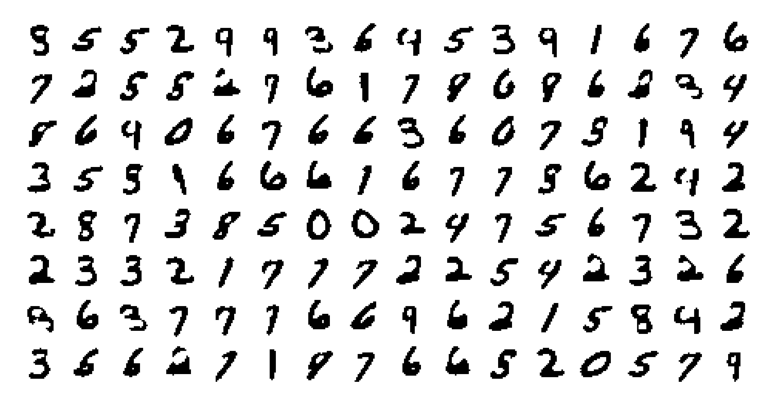

In [12]:
z = prior.sample((batch_size,))
with torch.no_grad():
    sample = decoder(z).mode
plot_images(sample.cpu())
plt.show()

Since the latent space is two-dimensional, we can visualize the samples at different points in the latent space.

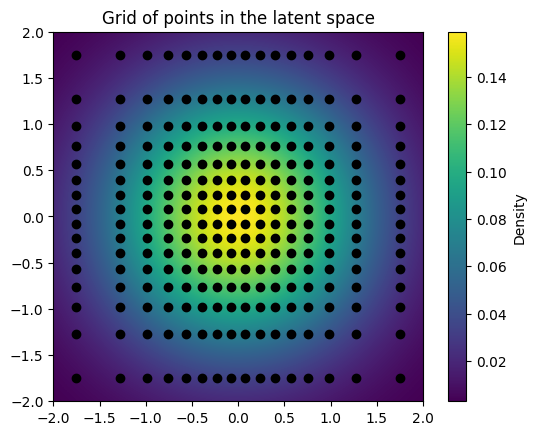

In [13]:
# ===== Create a grid of points in the latent space =====
grid_side = 16
grid_xy = D.Normal(0, 1).icdf(torch.linspace(0.04, 0.96, grid_side))
grid_x, grid_y = torch.meshgrid(grid_xy, grid_xy, indexing='xy')
grid = torch.stack([grid_x, -grid_y], dim=-1).view(-1, 2)
# ===== Create a second grid to visualize the density of the latent space =====
visu_xy = torch.linspace(-2, 2, 500)
visu_x, visu_y = torch.meshgrid(visu_xy, visu_xy, indexing='xy')
visu_grid = torch.stack([visu_x, visu_y], dim=-1)
# ===== Plot the density and the grid =====
fig, axis = plt.subplots()
density = prior.log_prob(visu_grid.to(device)).exp().cpu()
im = axis.imshow(density, extent=[-2, 2, -2, 2], origin='lower')
axis.scatter(grid[:, 0], grid[:, 1], color='black')
fig.colorbar(im, ax=axis, label='Density')
axis.set_title('Grid of points in the latent space')
plt.show()

We now visualize the samples produced by the decoder for each point of the latent space in the grid.
We observe that the encoder is able to transition smoothly between the different digits.

For certain samples, determining the intended digit can be inherently difficult.
For example, this is the case for certain interpolations between the digits 4 and 9.

Can you spot other such transitions?

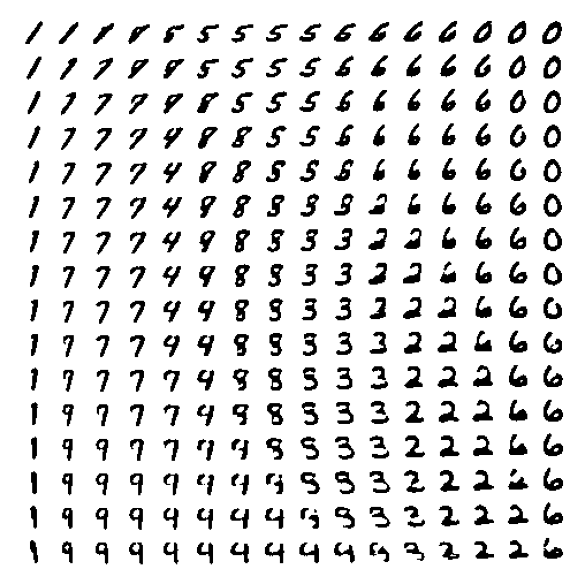

In [14]:
with torch.no_grad():
    sample = decoder(grid.to(device)).mode
plot_images(sample.cpu(), ncols=grid_side)
plt.show()

## 4. Encoding points to the latent space



We verify that the encoder is able to learn latent representations that are close for the same digits.

Notably, the digits 0 and 1 can often be easily distinguished. However, the representations for 4 and 9 are close.

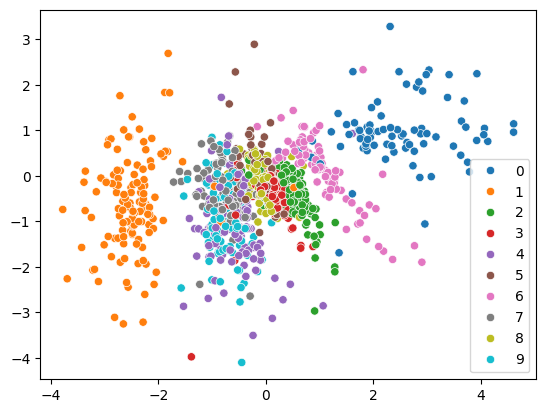

In [15]:
n_points = 1000

test_data = MNIST('./data', train=False, transform=transform)
test_data = Subset(test_data, range(n_points))
test_loader = DataLoader(test_data, batch_size=batch_size)

z_list = []
y_list = []
for x, y in test_loader:
    x = x.to(device).float()
    with torch.no_grad():
        z_dist = encoder(x)
    z_list.append(z_dist.base_dist.loc)
    y_list.append(y)

z = torch.cat(z_list, dim=0).cpu().numpy()
y = torch.cat(y_list, dim=0).cpu().numpy()

sns.scatterplot(
    x=z[:, 0],
    y=z[:, 1],
    hue=y.astype('str'),
    hue_order=[str(i) for i in range(10)],
)
plt.show()

## 5. Experiments

### 5.1. A smaller model

We now train a smaller model with less parameters.

In [22]:
encoder = Encoder(C_dim=4, H_dim=8, Z_dim=2).to(device)
decoder = Decoder(C_dim=4, H_dim=8, Z_dim=2).to(device)

print('Total parameters of the encoder:', params_count(encoder))
print('Total parameters of the decoder:', params_count(decoder))

train(encoder, decoder, train_loader, num_epochs=3)

Total parameters of the encoder: 10724
Total parameters of the decoder: 11473
epoch [1/3], step 1, loss:477.2190
epoch [1/3], step 101, loss:248.1693
epoch [1/3], step 201, loss:237.9850
epoch [1/3], step 301, loss:238.2525
epoch [1/3], step 401, loss:228.5058
epoch [2/3], step 501, loss:208.8735
epoch [2/3], step 601, loss:202.4410
epoch [2/3], step 701, loss:191.6658
epoch [2/3], step 801, loss:200.5347
epoch [2/3], step 901, loss:185.7777
epoch [3/3], step 1001, loss:187.2734
epoch [3/3], step 1101, loss:177.3262
epoch [3/3], step 1201, loss:177.8652
epoch [3/3], step 1301, loss:188.8458
epoch [3/3], step 1401, loss:170.8073


What do you observe?

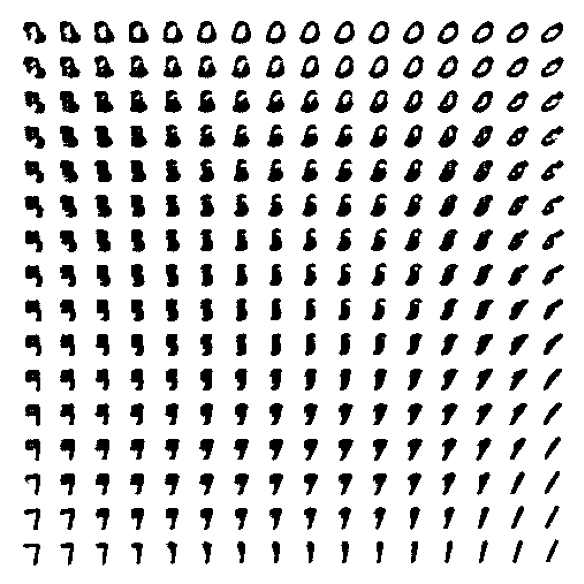

In [23]:
with torch.no_grad():
    sample = decoder(grid.to(device)).mode
plot_images(sample.cpu(), ncols=grid_side)
plt.show()

### 5.2. A smaller dataset

We consider a very small dataset of 8 samples shown here.

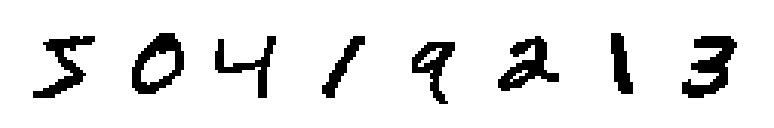

In [16]:
small_train_data = Subset(train_data, range(8))
small_train_loader = DataLoader(small_train_data, batch_size=batch_size)

first_batch = next(iter(small_train_loader))[0]
plot_images(first_batch.float())
plt.show()

We now train a VAE on this dataset.

In [17]:
encoder = Encoder(C_dim, H_dim, Z_dim).to(device)
decoder = Decoder(C_dim, H_dim, Z_dim).to(device)

train(encoder, decoder, small_train_loader, num_epochs=1000)

epoch [1/1000], step 1, loss:586.2294
epoch [101/1000], step 101, loss:212.1767
epoch [201/1000], step 201, loss:201.6956
epoch [301/1000], step 301, loss:31.2955
epoch [401/1000], step 401, loss:9.3683
epoch [501/1000], step 501, loss:10.6688
epoch [601/1000], step 601, loss:6.8521
epoch [701/1000], step 701, loss:8.3043
epoch [801/1000], step 801, loss:4.6932
epoch [901/1000], step 901, loss:7.1831


What do you observe?

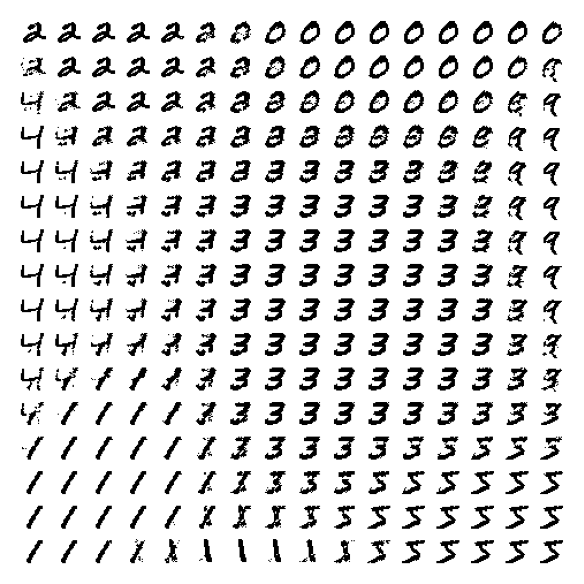

In [18]:
with torch.no_grad():
    sample = decoder(grid.to(device)).mode
plot_images(sample.cpu(), ncols=grid_side)
plt.show()